Let's open a capture file and export it into a more easily usable format...

In [ ]:
!apt-get install tshark
!tshark -r "capture_10_36_mon_5.pcapng" -R "wlan.fc.type_subtype == 0x04" -2 -T fields -e frame.number -e frame.time -e wlan.sa -e wlan.da -e wlan_radio.signal_dbm -e wlan.ssid -E header=y -E separator=, -E quote=d -E occurrence=f > capture.csv

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tshark is already the newest version (2.6.10-1~ubuntu18.04.0).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Running as user "root" and group "root". This could be dangerous.


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/Network measurements /

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import seaborn as sns 
import matplotlib.pyplot as plt


In [ ]:
#A locally administered address is assigned to a device by software or a network administrator, 
#overriding the burned-in address for physical devices. Locally administered addresses are distinguished 
#from universally administered addresses by setting (assigning the value of 1 to) 
#the second-least-significant bit of the first octet of the address. This bit is also referred to as the U/L bit, 
#short for Universal/Local, which identifies how the address is administered.

def is_local_mac(sa):
    first_octet = '0x'  + sa[0:2] #take the first octet of the MAC address (first two exadecimal values)
    first_octet = int(format(int(first_octet,16),'08b'),2) #transform the first octet in binary format over 8 bits
    mask = int(format(2,'08b'),2) #create the mask 00000010 (it's number 2 in decimal format)
    if(mask & first_octet == mask): #perform bitwise and and check if it's equal to mask
      return True
    else:
      return False
    
def extract_features(mac, df_flow):
    flow_features = {}

    flow_features['mac'] = mac
    flow_features['avg_rss'] = df_flow['wlan_radio.signal_dbm'].astype(float).mean()
    flow_features['mean_iat'] = pd.to_datetime(df_flow['frame.time']).diff(1).dt.total_seconds().iloc[1:].mean()

    return flow_features[flow_features != 'nan']


In [ ]:
cap = pd.read_csv('capture.csv')
cap = cap[cap['wlan.sa'].notna()]

cap['is_local'] = cap['wlan.sa'].apply(lambda x : is_local_mac(x))
display(cap)

universal_probes = cap[cap['is_local'] == False]
local_probes = cap[cap['is_local'] == True]

grouped_universal_probes = universal_probes.groupby(['wlan.sa'])
grouped_local_probes = local_probes.groupby(['wlan.sa'])

num_local = 0
num_universal = 0

LOCAL_DF = pd.DataFrame()
UNIVERSAL_DF = pd.DataFrame()
for sa,probes in grouped_universal_probes:
    features_per_mac = extract_features(sa, probes)
    UNIVERSAL_DF = UNIVERSAL_DF.append(features_per_mac, ignore_index = True)
display(UNIVERSAL_DF.head(3))

for sa,probes in grouped_local_probes:
    features_per_mac = extract_features(sa, probes)
    LOCAL_DF = LOCAL_DF.append(features_per_mac, ignore_index = True)
display(LOCAL_DF.head(3))

print('There were ' + str(LOCAL_DF.shape[0]) + ' local (randomized) MAC addresses and ' + str(UNIVERSAL_DF.shape[0]) + ' universal MAC addresses' )
# a lot of MACs! This is due to the randomization of the MAC addresses. One bit out of 46 can be put to 1 if it is a randomized address (local bit)

00:0c:42:ab:04:b4 -90.06796116504854 16.221966333333338 ['Adiesselle.it' '�Q{eYse�U��:\x1b']
00:ae:fa:75:3b:fb -67.5 43.95187167741935 []
00:cd:fe:4b:57:e2 -75.79166666666667 8.949067739130436 ['Apple Setup' 'Hotel Giardino sul Mare']
08:f6:8a:8f:46:04 -91.0 nan []
10:30:25:89:da:43 -77.66666666666667 59.971770272727284 ['Hotel Giardino sul Mare' 'shhhhh']
10:f1:f2:45:b5:8c -71.7 87.30389022222224 []
14:9d:09:bf:c4:06 -57.8 143.43034177777778 []
14:c2:13:7c:dc:d3 -83.33333333333333 29.21048 ['Hotel Giardino sul Mare']
18:65:90:d6:c6:99 -68.33333333333333 3.7408288000000005 ['Hotel Giardino sul Mare' 'Vodafone-WiFi']
1d:b4:35:3b:dc:6c -88.0 nan []
20:16:b9:b1:39:83 -64.5 14.94368094736842 [' ']
20:16:b9:b8:10:0a -64.0 84.14092560000002 ['Hotel Giardino sul Mare' 'LIPARISCHOOL']
24:18:1d:e2:5b:22 -90.0 nan []
24:af:ed:3e:ea:d0 -89.0 nan []
2c:f0:ee:04:af:00 -52.193548387096776 9.157192560975616 ['BRUFANI' 'Hotel Giardino sul Mare' 'LIPARISCHOOL' 'LIPARISCHOOL-5G'
 'NETGEAR05' 'virus_down

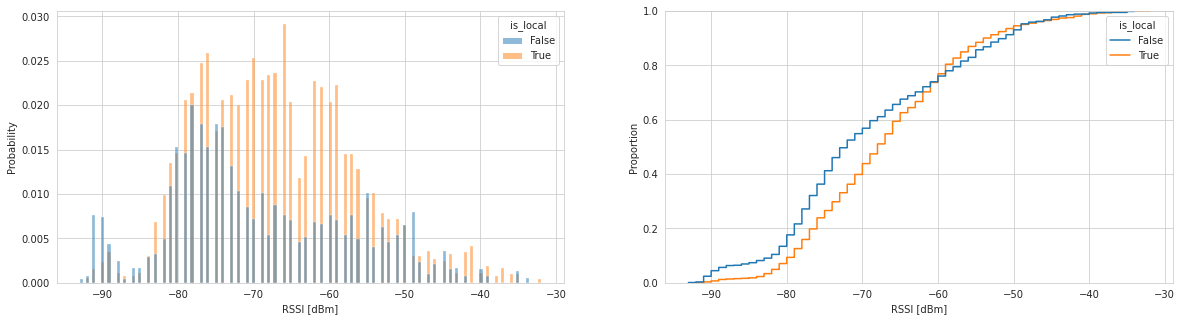

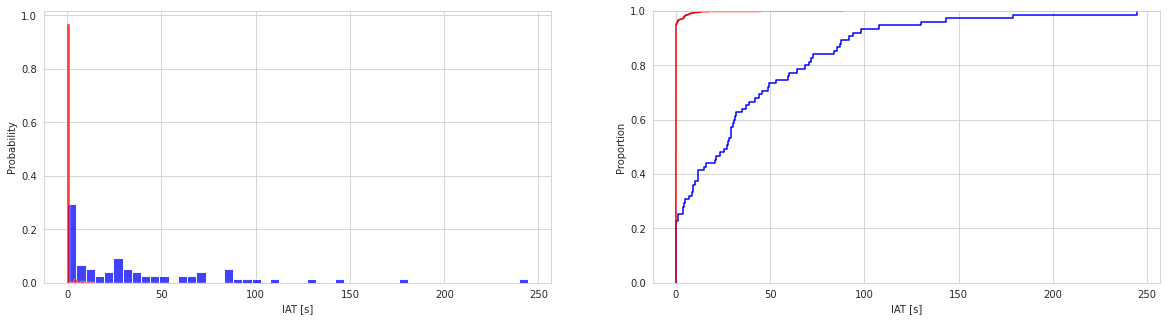

In [ ]:
# RSSI
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))
sns.set_style("whitegrid")

fig1 = sns.histplot(cap, x='wlan_radio.signal_dbm', hue='is_local', stat='probability', ax=ax1, bins=150)
fig1.set_xlabel('RSSI [dBm]')

fig2 = sns.ecdfplot(cap, x='wlan_radio.signal_dbm', hue='is_local', ax=ax2)
fig2.set_xlabel('RSSI [dBm]')

# IAT
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))
sns.set_style("whitegrid")

fig1 = sns.histplot(UNIVERSAL_DF['mean_iat'], stat='probability', ax=ax1, bins=50, color ='b')
fig1 = sns.histplot(LOCAL_DF['mean_iat'], stat='probability', ax=ax1, bins=50, color='r')
fig1.set_xlabel('IAT [s]')

fig2 = sns.ecdfplot(UNIVERSAL_DF['mean_iat'], ax=ax2, color = 'b')
fig2 = sns.ecdfplot(LOCAL_DF['mean_iat'], ax=ax2, color = 'r')
fig2.set_xlabel('IAT [s]')

In [ ]:
import requests
import json

SSIDs = ['AP-BONOLA', 'Apple Store', 'D-Link-782084', 'FASTWEB-1-A9A463',
 'Hotel Giardino sul Mare', 'LIVINGFREE', 'Lab-netgroup', 'Leda Hotel',
 'eduroam', 'iPhone di marco', 'mpaou.uth.gr', 'qba']
 
for ssid in SSIDs:
  query = 'https://api.wigle.net/api/v2/network/search?onlymine=false&freenet=false&paynet=false&ssid=' + ssid
  response = requests.get(query, auth=('AIDb42d371635e0ef3b7cb3fe0f60054975', '6ce87b868cbe6ecc204b3ab17dc83887'), headers={'Accept': 'application/json'})
  res = json.loads(response.content)
  if res['totalResults']>0:
    print(ssid + ': ' +res['results'][0]['region'], res['results'][0]['postalcode'], res['results'][0]['trilat'], res['results'][0]['trilong'])

Apple Store: England TW12 3XZ 51.4249115 -0.37916499
LIVINGFREE: WA 98195-2350 47.65229416 -122.29620361
eduroam: CO 80437 39.69000244 -105.35848999
iPhone di marco: Lombardia 27012 45.25522614 9.14016533
qba: województwo mazowieckie 05-090 52.1640892 20.92713737
